## Data prepare

In [1]:
import os.path as osp
import numpy as np
import numpy as np
from tqdm import tqdm_notebook, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
%matplotlib inline
import skimage

In [2]:
def numpy_read(filename):
    if filename is None:
        return None

    filedir, basename = osp.split(filename)
    basename, _ext = osp.splitext(basename)

    parts = basename.split('_')
    assert(len(parts) >= 3)
    dtype, shape = parts[-2], parts[-1]
    dtype = np.dtype(dtype)
    shape = tuple(map(int, shape.split('x')))
    return np.memmap(
        filename,
        mode='readonly',
        shape=shape,
        dtype=dtype)


In [3]:
letters_inp = numpy_read('letters_inp_float32_46632x16x16x1.raw')
letters_out = numpy_read('letters_out_float32_46632x35.raw')
print(letters_out.sum(axis=0))

[ 1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.
  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.  1943.
  1943.  1943.  1943.  1943.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.]


In [4]:
letters_inp = np.array(letters_inp)
letters_out = np.array(letters_out)

In [5]:
def big_figure(imgs, hc, wc, shift=2):
    assert(len(imgs) == hc*wc)
    
    # or vice versa
    h = len(imgs[0])
    w = len(imgs[0][0])
    
    
    H = hc * h + shift * (hc - 1)
    W = wc * w + shift * (wc - 1)
    
    pic = np.ndarray([H, W]) * 0.  
    for i in range(hc):
        for j in range(wc):
            sx = (h + shift) * i
            sy = (w + shift) * j
            pic[sx: sx + h, sy: sy + w] = imgs[i*wc + j][:,:,0]
            
    return pic

def to_index(one_hot):
    return sum(i*x for (i,x) in enumerate(one_hot))

def to_one_hot(index):
    out = np.zeros([len(letters_out[0])])
    out[int(index)] = 1
    return out

### Lets make some noise

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

In [7]:
def show_pict( by_val_aug, by_val, num_example, num_elements_of_exm):
    pics = []
    for ind in (range(num_example)):
        if (by_val != False):
            pics += [by_val_aug[ind][i] if i !=0 else by_val[ind][1] for i in range(num_elements_of_exm)]
        else:
            pics += [by_val_aug[ind][i] for i in range(num_elements_of_exm)]

    pic = big_figure(pics, num_example, num_elements_of_exm)
    plt.figure(figsize=(8,8))
    plt.imshow(pic, cmap='gray')
    plt.show()

In [8]:
blur_mean = 0.4
blur_dev = 0.2
blur_min = 0.1
blur_max = 0.5

scale_mean = 1
scale_dev = 0.2
scale_min = 0.8
scale_max = 1.2

rotate_mean = 0
rotate_dev = 5
rotate_min = -10
rotate_max = 10

gamma_mean = 1
gamma_dev = 0.2
gamma_min = 0.8
gamma_max = 1.25

num_drops = 3

In [9]:
seq = iaa.Sequential([
    
    iaa.GaussianBlur(sigma = iap.Clip(iap.Normal(blur_mean, blur_dev),blur_min,blur_max)),
    
    iaa.Affine(
        scale={"x": iap.Clip(iap.Normal(scale_mean, scale_dev),scale_min,scale_max), 
               "y": iap.Clip(iap.Normal(scale_mean, scale_dev),scale_min,scale_max)},
        
        rotate=iap.Clip(iap.Normal(rotate_mean, rotate_dev),rotate_min,rotate_max))
    ], 
    random_order=True) # apply augmenters in random order

In [10]:
def gamm_corr(imges, mean=gamma_mean, dev=gamma_dev, min_val=gamma_min, max_val=gamma_max):
    res_images = []
    for img in imges:
        gamma = np.random.normal(mean, dev)
        if gamma<min_val:
            gamma=min_val
        if gamma>max_val:
            gamma=max_val
        res_images.append(skimage.exposure.adjust_gamma(img, gamma=gamma))
    return np.array(res_images)

In [11]:
def drop_img(images, num_drop):
    drop_shape_list = [(5,5), (4,5), (5,4)]
    
    res_images = []
    for img_ in images:
        img = img_.copy()
        for i in range(num_drop):
            drop_shape = random.choice(drop_shape_list)
            rand_h = random.choice(range(0, img.shape[0] - drop_shape[0]))
            rand_w = random.choice(range(0, img.shape[1] - drop_shape[1]))
            img[rand_h:rand_h+drop_shape[0], rand_w:rand_w+drop_shape[1]] = random.randint(10, 200)/255
        res_images.append(img)
    return np.array(res_images)

In [12]:
def batch_gen(X,y, batch_size, min_num_in_group, max_num_in_group):
    imges_index = list(range(len(X)))
    while True:
        
        num_in_group = random.randint(min_num_in_group, max_num_in_group)
        if batch_size>len(imges_index):
            imges_index = list(range(X.shape[0]))
            yield np.array([False]), np.array([False]), np.array([False])
            
        rand_indexes = random.sample(imges_index, batch_size)
        for k in rand_indexes:
            imges_index.remove(k)
        
        res_group = []
        for k in range(num_in_group):
            res_group.append(drop_img(gamm_corr(seq.augment_images(X[rand_indexes])), num_drop=num_drops))
        res_group = np.stack(res_group,axis=1)
        yield np.array(res_group), y[rand_indexes], X[rand_indexes]

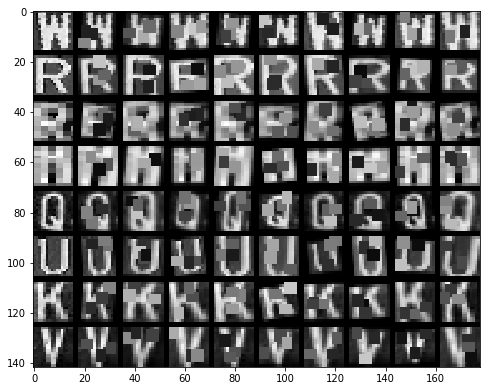

In [13]:
%matplotlib inline
num_example = 8
max_elements = 10
empty = np.zeros([16,16,1])
pics = []
gen = batch_gen(letters_inp,letters_out, 1, max_elements-1,max_elements-1)
# xx, yy, orig = next(gen)

for ind in (range(num_example)):
    imgs,yy,orig = next(gen)
    #print(imgs.shape)
    pics += [orig[0]]+ list(imgs[0]) + [empty] * (max_elements - len(imgs[0])-1) 

plt.figure(figsize=(8,8))
pic = big_figure(pics, num_example, max_elements)
plt.imshow(pic, cmap='gray')
plt.show()

## Experements with model

In [14]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Activation, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score
import keras
import keras.backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


### Trainingn on single images

#### Trainingn on single images

In [15]:
def gen_for_test(X, Y, batch_size = 50):
    gen_test = batch_gen(X,Y, batch_size, 10, 10)
    while True:
        xx, yy, __ = next(gen_test)
        yy = np.repeat(yy,repeats=xx.shape[1], axis=0)
        xx = xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)
        yield xx, yy

In [16]:
# учитываем, что всего 24 класса
X_tr, X_te, Y_tr, Y_te = train_test_split(letters_inp,
                                          np.apply_along_axis(lambda x: x[:24],axis=1,arr=letters_out), 
                                          test_size=0.7,
                                          stratify = np.apply_along_axis(lambda x: x[:24],axis=1,arr=letters_out),
                                          random_state=42)

In [17]:
X_tr_add, X_all_test, Y_tr_add, Y_all_test = train_test_split(X_te,
                                                              Y_te, 
                                                              test_size=0.5,
                                                              stratify = np.argmax(Y_te, axis=1),
                                                              random_state=42)

In [18]:
dataset_10 = []
target_10 = []
for i in tqdm_notebook(range(24)):
    dataset_10.append(X_tr[np.where(np.argmax(Y_tr,axis=1) == i)[0][:10]])
    target_10.append(Y_tr[np.where(np.argmax(Y_tr,axis=1) == i)[0][:10]])
dataset_10 = np.array(dataset_10)
target_10 = np.array(target_10)

dataset_10 = dataset_10.reshape(240, 16, 16, 1)
target_10 = target_10.reshape(240,24)

dataset_10, _, target_10, _ = train_test_split(dataset_10,
                                          target_10, 
                                          test_size=0.,
                                          random_state=42)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [19]:
dataset_10.shape

(240, 16, 16, 1)

(array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.,  10.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

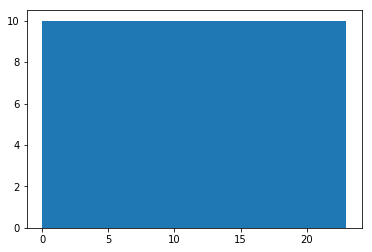

In [20]:
# распределение по классам
plt.hist(np.argmax(target_10, axis=1), bins=24)

In [18]:
gen_val = gen_for_test(X_all_test, Y_all_test, batch_size = 1000)
X_val, Y_val = next(gen_val)
print(X_val.shape)

(10000, 16, 16, 1)


In [19]:
batch_size = 64
group_size_min = 10
group_size_max = 10
num_classes = 24 # Y_tr.shape[1]
epochs = 20
img_rows, img_cols = 16, 16
input_shape = (img_rows, img_cols, 1)

In [31]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', name='additional_out'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

filepath="./weights/Best_CNN_with_noise.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
hist = keras.callbacks.History()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [25]:
X_train = []
Y_train = []
gen_train = batch_gen(dataset_10,target_10, 5, group_size_min, group_size_max)
#gen_train = batch_gen(X_tr,Y_tr, 5, 5, 5)

xx, yy,__ = next(gen_train)
X_train = xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)
Y_train = np.repeat(yy, repeats=xx.shape[1], axis=0)

while xx.any() != False:
    xx, yy,__ = next(gen_train)
    if (xx.any() == False):
        break
    X_train = np.vstack((X_train, xx.reshape(xx.shape[0]*xx.shape[1], 16,16,1)))
    Y_train = np.vstack((Y_train, np.repeat(yy,repeats=xx.shape[1], axis=0)))

In [26]:
X_train.shape

(2400, 16, 16, 1)

In [27]:
Y_train.shape

(2400, 24)

In [28]:
for i in np.unique(np.argmax(Y_train, axis=1)):
    print ("Class ", i, (np.argmax(Y_train, axis=1) == i).sum())

Class  0 100
Class  1 100
Class  2 100
Class  3 100
Class  4 100
Class  5 100
Class  6 100
Class  7 100
Class  8 100
Class  9 100
Class  10 100
Class  11 100
Class  12 100
Class  13 100
Class  14 100
Class  15 100
Class  16 100
Class  17 100
Class  18 100
Class  19 100
Class  20 100
Class  21 100
Class  22 100
Class  23 100


In [32]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data = (X_val, Y_val),
          callbacks = [checkpoint])

Train on 2400 samples, validate on 10000 samples
Epoch 1/20
2400/2400 [==============================] - 3s 1ms/step - loss: 3.1247 - acc: 0.0683 - val_loss: 2.9416 - val_acc: 0.1371
Epoch 2/20
2400/2400 [==============================] - 3s 1ms/step - loss: 2.3427 - acc: 0.3096 - val_loss: 2.1990 - val_acc: 0.3350
Epoch 3/20
2400/2400 [==============================] - 2s 1ms/step - loss: 1.7823 - acc: 0.4642 - val_loss: 2.0396 - val_acc: 0.4152
Epoch 4/20
2400/2400 [==============================] - 2s 1ms/step - loss: 1.4645 - acc: 0.5363 - val_loss: 1.6347 - val_acc: 0.4909
Epoch 5/20
2400/2400 [==============================] - 3s 1ms/step - loss: 1.2611 - acc: 0.6088 - val_loss: 1.6003 - val_acc: 0.5059
Epoch 6/20
2400/2400 [==============================] - 3s 1ms/step - loss: 1.0902 - acc: 0.6400 - val_loss: 1.4419 - val_acc: 0.5558
Epoch 7/20
2400/2400 [==============================] - 2s 1ms/step - loss: 0.9423 - acc: 0.6871 - val_loss: 1.4496 - val_acc: 0.5502
Epoch 8/20
24

In [29]:
model.load_weights(filepath)

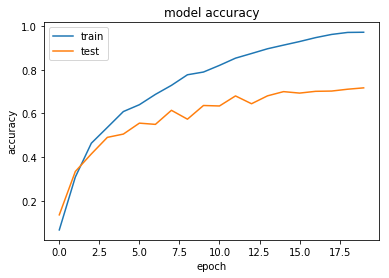

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#### Testing on single images

In [34]:
gen_test = gen_for_test(X_all_test, Y_all_test)

In [35]:
score = model.evaluate_generator(gen_test, steps=int((X_all_test.shape[0])/50)-1)

In [36]:
print("Accuracy score: ", score[1])

Accuracy score:  0.718799999127


#### Testing Answer Averaging

In [37]:
def test_predict( X, Y, num_in_group, model = model):
    Y_pred = []
    Y_true = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)

    xx, yy,__ = next(gen_train)
    
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_true.append(yy[i])
            Y_pred.append(model.predict(xx[i]).mean(axis=0))
            
        xx, yy,__ = next(gen_train)
        
    return np.array(Y_true), np.array(Y_pred)

In [38]:
y_true, y_pred = test_predict(X_all_test, Y_all_test, 10, model)

KeyboardInterrupt: 

In [35]:
elements_in_group = list(range(0,21,3))

In [41]:
elements_in_group = (2, 3, 5, 9)

In [42]:
results = []
for i in tqdm_notebook(elements_in_group):
    y_true, y_pred = test_predict(X_all_test, Y_all_test, i, model)
    results.append(accuracy_score([np.argmax(x) for x in y_true], [np.argmax(x) for x in y_pred]))
results = np.array(results)

In [37]:
y_true.shape

(16300, 24)

In [43]:
results

array([ 0.80907975,  0.85907975,  0.90233129,  0.92233129])

In [39]:
elements_in_group

[1, 3, 6, 9, 12, 15, 18]

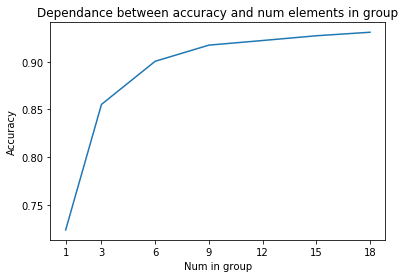

In [40]:
plt.plot(elements_in_group, results)
plt.xticks(elements_in_group, elements_in_group)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')

In [41]:
np.save('results',results)

### Training additional model

#### Generatge dataset for additional model

In [42]:
from keras.models import Model

In [43]:
layer_name = 'additional_out'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [44]:
def get_features(array):
    features = []
    features.append(array.min())
    features.append(array.max())
    features.append(array.std())
    features.append(array.mean())
    return np.array(features)

In [45]:
def get_add_dataset(X, Y, model, num_in_group = 5):
    X_add = []
    Y_add = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)


    xx, yy,__ = next(gen_train)
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_add.append(yy[i])
            featured = np.array([get_features(x) for x in model.predict(xx[i]).T]).flatten()
            X_add.append(featured)

        xx, yy,__ = next(gen_train)
    return np.array(X_add), np.array(Y_add)

In [46]:
X_add, Y_add = get_add_dataset(X_tr_add, Y_tr_add, intermediate_layer_model)

In [47]:
X_add.shape

(16300, 512)

In [48]:
Y_add.shape

(16300, 24)

#### Extra models training

In [49]:
extra_model = Sequential()
extra_model.add(Dense(128, input_shape=(X_add.shape[1],)))
extra_model.add(Dropout(0.2))
extra_model.add(Dense(256))
extra_model.add(Dropout(0.3))
#model.add(Dropout(0.25))
#model.add(Dropout(0.5))
extra_model.add(Dense(num_classes, activation='softmax'))

hist = keras.callbacks.History()

extra_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [50]:
history = extra_model.fit(X_add, Y_add, 
                    batch_size=64,
                    epochs=100)

Epoch 1/100
16300/16300 [==============================] - 1s 60us/step - loss: 1.3245 - acc: 0.7007
Epoch 2/100
16300/16300 [==============================] - 1s 53us/step - loss: 0.3911 - acc: 0.8829
Epoch 3/100
16300/16300 [==============================] - 1s 56us/step - loss: 0.3019 - acc: 0.9094
Epoch 4/100
16300/16300 [==============================] - 1s 66us/step - loss: 0.2614 - acc: 0.9252
Epoch 5/100
16300/16300 [==============================] - 1s 68us/step - loss: 0.2393 - acc: 0.9311
Epoch 6/100
16300/16300 [==============================] - 1s 63us/step - loss: 0.2225 - acc: 0.9328
Epoch 7/100
16300/16300 [==============================] - 1s 62us/step - loss: 0.2053 - acc: 0.9388
Epoch 8/100
16300/16300 [==============================] - 1s 59us/step - loss: 0.1931 - acc: 0.9440
Epoch 9/100
16300/16300 [==============================] - 1s 59us/step - loss: 0.1756 - acc: 0.9485
Epoch 10/100
16300/16300 [==============================] - 1s 58us/step - loss: 0.1739 - a

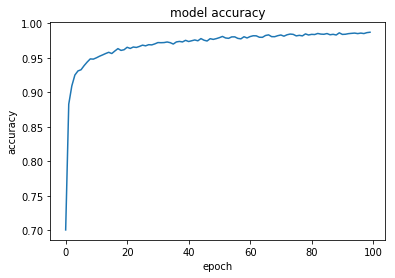

In [51]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [52]:
#import xgboost
import lightgbm

lgb = lightgbm.LGBMClassifier()
lgb.fit(X_add, np.argmax(Y_add, axis=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [54]:
cross_val_score(lgb, X_add, np.argmax(Y_add, axis=1), cv=2)

array([ 0.95057034,  0.94697435])

### Testing CNN + additional model

In [53]:
def print_score(name_additional, elements_in_group,results):
    print("Additional model - ", name_additional)
    for i,j in zip(elements_in_group, results):
        print("     Num elements in group: {}, score: {:.3f}".format(i, j))

In [54]:
def all_test_pred( X, Y, num_in_group, model, extra_model = extra_model):
    Y_pred = []
    Y_true = []
    gen_train = batch_gen(X,Y, 50, num_in_group, num_in_group)

    xx, yy,__ = next(gen_train)
    
    while xx.any() != False:
        for i in range(xx.shape[0]):
            Y_true.append(yy[i])
            #Y_pred.append(model.predict(xx[i]).mean(axis=0))
            featured_x = np.array([get_features(x) for x in model.predict(xx[i]).T]).flatten()
            Y_pred.append(extra_model.predict(featured_x.reshape(1, featured_x.shape[0])))
            
        xx, yy,__ = next(gen_train)
        
    return np.array(Y_true), np.array(Y_pred)

(array([ 204.,  207.,  209.,  199.,  207.,  222.,  217.,  212.,  203.,
         210.,  200.,  212.,  221.,  204.,  226.,  218.,  203.,  201.,
         211.,  215.,  208.,  194.,  188.,  209.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

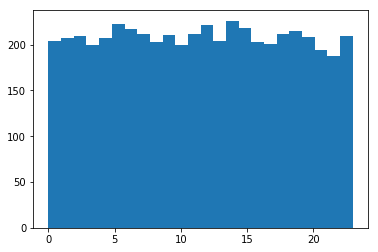

In [55]:
plt.hist(np.argmax(Y_all_test[:5000],axis=1), bins=24)

In [56]:
elements_in_group_all = list(range(0,21,3))
elements_in_group_all[0] = 1
results_all = []
for i in tqdm_notebook(elements_in_group_all):
    y_true, y_pred = all_test_pred(X_all_test[:5000], Y_all_test[:5000], num_in_group=i,model = intermediate_layer_model, extra_model=extra_model)
    results_all.append(accuracy_score([np.argmax(x) for x in y_true], [np.argmax(x) for x in y_pred]))
results_all = np.array(results_all)
#y_pred_dense = y_pred.copy()

In [57]:
elements_in_group_xgb = list(range(0,21,3))
elements_in_group_xgb[0] = 1
results_xgb = []
for i in tqdm_notebook(elements_in_group_xgb):
    y_true, y_pred = all_test_pred(X_all_test[:5000], Y_all_test[:5000], num_in_group=i,model = intermediate_layer_model, extra_model=lgb)
    results_xgb.append(accuracy_score([np.argmax(x) for x in y_true], y_pred))
results_xgb = np.array(results_xgb)
#y_pred_lgb = y_pred.copy()

NN
Extra model trained on the groups of 5


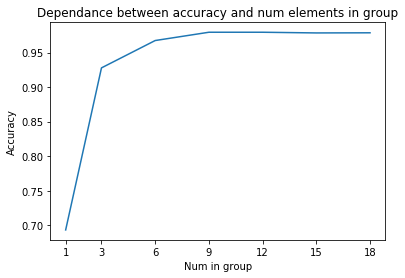

In [61]:
plt.plot(elements_in_group_all, results_all)
plt.xticks(elements_in_group_all, elements_in_group_all)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')
print("NN")
print("Extra model trained on the groups of 5")

XGB
Extra model trained on the groups of 5


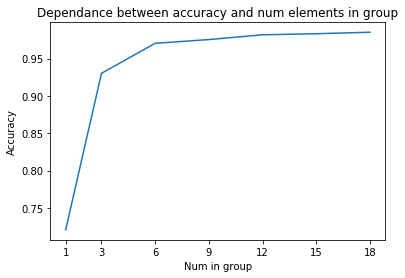

In [62]:
plt.plot(elements_in_group_xgb, results_xgb)
plt.xticks(elements_in_group_xgb, elements_in_group_xgb)
# plt.yticks(results, results)
plt.title("Dependance between accuracy and num elements in group")
plt.ylabel('Accuracy')
plt.xlabel('Num in group')
print("XGB")
print("Extra model trained on the groups of 5")

In [63]:
print_score('lgb', elements_in_group_xgb, results_xgb)
print_score('Dense', elements_in_group_all, results_all)
print_score('Mean', elements_in_group, results)

Additional model -  lgb
     Num elements in group: 1, score: 0.721
     Num elements in group: 3, score: 0.930
     Num elements in group: 6, score: 0.970
     Num elements in group: 9, score: 0.975
     Num elements in group: 12, score: 0.982
     Num elements in group: 15, score: 0.983
     Num elements in group: 18, score: 0.985
Additional model -  Dense
     Num elements in group: 1, score: 0.693
     Num elements in group: 3, score: 0.928
     Num elements in group: 6, score: 0.967
     Num elements in group: 9, score: 0.979
     Num elements in group: 12, score: 0.979
     Num elements in group: 15, score: 0.978
     Num elements in group: 18, score: 0.979
Additional model -  Mean
     Num elements in group: 1, score: 0.724
     Num elements in group: 3, score: 0.855
     Num elements in group: 6, score: 0.900
     Num elements in group: 9, score: 0.917
     Num elements in group: 12, score: 0.922
     Num elements in group: 15, score: 0.927
     Num elements in group: 18, score

In [64]:
elements_in_group

[1, 3, 6, 9, 12, 15, 18]

In [74]:
# old results
#print_score('lgb', elements_in_group_xgb, results_xgb)
print_score('Dense', elements_in_group_all, np.load('results_all.npy'))
print_score('Mean', elements_in_group, results)

Additional model -  Dense
     Num elements in group: 1, score: 0.712
     Num elements in group: 3, score: 0.883
     Num elements in group: 6, score: 0.940
     Num elements in group: 9, score: 0.953
     Num elements in group: 12, score: 0.958
     Num elements in group: 15, score: 0.958
     Num elements in group: 18, score: 0.959
Additional model -  Mean
     Num elements in group: 1, score: 0.719
     Num elements in group: 3, score: 0.858
     Num elements in group: 6, score: 0.908
     Num elements in group: 9, score: 0.922
     Num elements in group: 12, score: 0.929
     Num elements in group: 15, score: 0.932
     Num elements in group: 18, score: 0.936


------

- model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))              
- model.add(Conv2D(32, (1, 1), activation='relu'))
- model.add(Conv2D(32, (3, 3), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(MaxPooling2D(pool_size=(2, 2)))
- model.add(Flatten())
- model.add(Dense(128, activation='relu', name='additional_out'))
- model.add(Dense(num_classes, activation='softmax'))

## Unite net

### Training

In [21]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout

#### Variant 1

- model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))              
- model.add(Conv2D(32, (1, 1), activation='relu'))
- model.add(Conv2D(32, (3, 3), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(MaxPooling2D(pool_size=(2, 2)))
- model.add(Flatten())
- model.add(Dense(128, activation='relu', name='additional_out'))

Here is MEAN_LAYER
- model.add(Dense(num_classes, activation='softmax'))

In [22]:
def gen_for_unite(X, Y, batch_size = 50, num_in_group = 2):
    gen_test = batch_gen(X,Y, batch_size, num_in_group, num_in_group)
    xx, yy, __ = next(gen_test)
    while True:
        xx, yy, __ = next(gen_test)
        if xx.any() == False:
            continue
        xx_out = []
        for i in range(num_in_group):
            xx_out.append(xx[:,i,:,:,:])
        #yield [xx[:,0,:,:,:], xx[:,1,:,:,:]], yy
        yield xx_out, yy

In [48]:
def conv_cnn_1():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

In [49]:
def ensemble_1(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    
    y = Dense(24, activation='softmax')(middle_average) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [50]:
#dataset_10,target_10

In [47]:
def gen_for_unite(X, Y, batch_size = 50, num_in_group = 2):
    gen_test = batch_gen(X,Y, batch_size, num_in_group, num_in_group)
    xx, yy, __ = next(gen_test)
    while True:
        xx, yy, __ = next(gen_test)
        if xx.any() == False:
            continue
        xx_out = []
        for i in range(num_in_group):
            xx_out.append(xx[:,i,:,:,:])
        #yield [xx[:,0,:,:,:], xx[:,1,:,:,:]], yy
        yield xx_out, yy

In [51]:
def print_training_curv(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [117]:
def creating_training_net (cnn, ensemble,num_in_group, num_epochs):
    single_cnn = cnn()
    ensemble_model_1 = ensemble(single_cnn, num_in_group)
    ensemble_model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 
    
    elements_on_val = 250
    gen_train = gen_for_unite(dataset_10, target_10, batch_size = 60, num_in_group = num_in_group)
    gen_val = gen_for_unite(X_all_test[:elements_on_val], Y_all_test[:elements_on_val], batch_size = 50, num_in_group = num_in_group)
    
    hist = ensemble_model_1.fit_generator(gen_train, steps_per_epoch = int((dataset_10.shape[0])/60)-1, epochs=num_epochs, 
                                  validation_data = gen_val, validation_steps = int((X_all_test[:elements_on_val].shape[0])/50)-1)
    print_training_curv(hist)
    return ensemble_model_1

Epoch 1/80
3/3 [==============================] - 1s 497ms/step - loss: 3.1800 - acc: 0.0611 - val_loss: 3.1696 - val_acc: 0.0400
Epoch 2/80
3/3 [==============================] - 0s 150ms/step - loss: 3.1716 - acc: 0.0611 - val_loss: 3.1661 - val_acc: 0.0750
Epoch 3/80
3/3 [==============================] - 0s 143ms/step - loss: 3.1641 - acc: 0.0778 - val_loss: 3.1566 - val_acc: 0.0650
Epoch 4/80
3/3 [==============================] - 0s 144ms/step - loss: 3.1506 - acc: 0.0500 - val_loss: 3.1317 - val_acc: 0.0600
Epoch 5/80
3/3 [==============================] - 0s 150ms/step - loss: 3.1242 - acc: 0.0611 - val_loss: 3.1009 - val_acc: 0.0650
Epoch 6/80
3/3 [==============================] - 0s 146ms/step - loss: 3.0694 - acc: 0.0889 - val_loss: 3.0443 - val_acc: 0.1150
Epoch 7/80
3/3 [==============================] - 0s 144ms/step - loss: 3.0299 - acc: 0.1611 - val_loss: 2.9428 - val_acc: 0.1950
Epoch 8/80
3/3 [==============================] - 0s 146ms/step - loss: 2.9140 - acc: 0.23

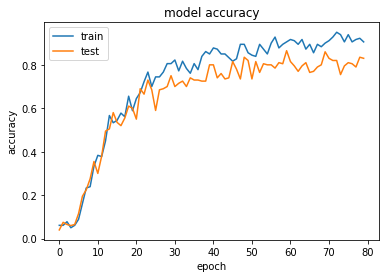

In [83]:
ens_model = Model
ens_model = creating_training_net (conv_cnn_1, ensemble_1, num_in_group = 3, num_epochs = 80)

In [34]:
num_in_group = 3
gen_test = gen_for_unite(X_all_test, Y_all_test, batch_size = 50, num_in_group = num_in_group)
score = ens_model.evaluate_generator(gen_test, steps=int((X_all_test.shape[0])/50)-1)
print(score[1])

0.975569232611


num_in_group = 3

#### Variant 2

- model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))              
- model.add(Conv2D(32, (1, 1), activation='relu'))
- model.add(Conv2D(32, (3, 3), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(MaxPooling2D(pool_size=(2, 2)))

Here is MEAN_LAYER
- model.add(Flatten())
- model.add(Dense(128, activation='relu', name='additional_out'))
- model.add(Dense(num_classes, activation='softmax'))

In [343]:
def conv_cnn_2():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    model = Model(model_input, x, name='CNN_unit')
    return model

In [344]:
def ensemble_2(cnn, num_cnn):
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array] #[cnn(inp_1), cnn(inp_2)]
    middle_average = Average()(outputs)
    flatten = Flatten()(middle_average)
    dense_1 = Dense(128, activation='relu')(flatten)
    y = Dense(24, activation='softmax')(dense_1)
    
    model = Model(inputs =inp_array, outputs = y, name='ensemble')
    
    return model

In [345]:
num_in_group = 3

In [346]:
single_cnn_2 = conv_cnn_2()
ensemble_model_2 = ensemble_2(single_cnn_2, num_in_group)
ensemble_model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 

In [347]:
gen_train = gen_for_unite(X_tr_add, Y_tr_add, batch_size = 50, num_in_group = num_in_group)
ensemble_model_2.fit_generator(gen_train, steps_per_epoch = int((X_all_test.shape[0])/50)-1, epochs=10)

Epoch 1/10
325/325 [==============================] - 23s 71ms/step - loss: 0.9799 - acc: 0.7066
Epoch 2/10
325/325 [==============================] - 25s 76ms/step - loss: 0.2719 - acc: 0.9141
Epoch 3/10
325/325 [==============================] - 23s 71ms/step - loss: 0.1863 - acc: 0.9413
Epoch 4/10
325/325 [==============================] - ETA: 0s - loss: 0.1498 - acc: 0.9548- ETA: 1s - loss: 0.15 - 23s 70ms/step - loss: 0.1496 - acc: 0.9549
Epoch 5/10
325/325 [==============================] - 22s 69ms/step - loss: 0.1261 - acc: 0.9616
Epoch 6/10
325/325 [==============================] - 22s 68ms/step - loss: 0.1109 - acc: 0.9659
Epoch 7/10
325/325 [==============================] - 22s 69ms/step - loss: 0.0904 - acc: 0.9741
Epoch 8/10
325/325 [==============================] - 23s 70ms/step - loss: 0.0841 - acc: 0.9748
Epoch 9/10
325/325 [==============================] - 24s 73ms/step - loss: 0.0799 - acc: 0.9761
Epoch 10/10
325/325 [==============================] - 24s 75ms/st

In [348]:
gen_test = gen_for_unite(X_all_test, Y_all_test, batch_size = 50, num_in_group = num_in_group)
score = ensemble_model_2.evaluate_generator(gen_test, steps=int((X_all_test.shape[0])/50)-1)
print(score[1])

0.97526154023


num_in_group = 3

In [63]:
# OLD RESULTS

Additional model -  lgb
     Num elements in group: 1, score: 0.721
     Num elements in group: 3, score: 0.930
     Num elements in group: 6, score: 0.970
     Num elements in group: 9, score: 0.975
     Num elements in group: 12, score: 0.982
     Num elements in group: 15, score: 0.983
     Num elements in group: 18, score: 0.985
Additional model -  Dense
     Num elements in group: 1, score: 0.693
     Num elements in group: 3, score: 0.928
     Num elements in group: 6, score: 0.967
     Num elements in group: 9, score: 0.979
     Num elements in group: 12, score: 0.979
     Num elements in group: 15, score: 0.978
     Num elements in group: 18, score: 0.979
Additional model -  Mean
     Num elements in group: 1, score: 0.724
     Num elements in group: 3, score: 0.855
     Num elements in group: 6, score: 0.900
     Num elements in group: 9, score: 0.917
     Num elements in group: 12, score: 0.922
     Num elements in group: 15, score: 0.927
     Num elements in group: 18, score

#### Variant 3

- model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))              
- model.add(Conv2D(32, (1, 1), activation='relu'))
- model.add(Conv2D(32, (3, 3), activation='relu'))

Here is MEAN_LAYER
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(MaxPooling2D(pool_size=(2, 2)))
- model.add(Flatten())
- model.add(Dense(128, activation='relu', name='additional_out'))
- model.add(Dense(num_classes, activation='softmax'))

In [33]:
def conv_cnn_3():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)

    model = Model(model_input, x, name='CNN_unit')
    return model

In [34]:
def ensemble_3(cnn, num_cnn):
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array] #[cnn(inp_1), cnn(inp_2)]
    middle_average = Average()(outputs)
    x = Conv2D(16, (1, 1), activation='relu')(middle_average)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(x)
    dense_1 = Dense(128, activation='relu')(flatten)
    y = Dense(24, activation='softmax')(dense_1)
    
    model = Model(inputs =inp_array, outputs = y, name='ensemble')
    
    return model

In [35]:
num_in_group = 3

In [36]:
single_cnn_3 = conv_cnn_3()
ensemble_model_3 = ensemble_3(single_cnn_3, num_in_group)
ensemble_model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 

In [37]:
gen_train = gen_for_unite(X_tr_add, Y_tr_add, batch_size = 50, num_in_group = num_in_group)
ensemble_model_3.fit_generator(gen_train, steps_per_epoch = int((X_all_test.shape[0])/50)-1, epochs=10)

Epoch 1/10
 45/325 [===>..........................] - ETA: 20s - loss: 2.8168 - acc: 0.1996

KeyboardInterrupt: 

In [521]:
gen_test = gen_for_unite(X_all_test, Y_all_test, batch_size = 50, num_in_group = num_in_group)
score = ensemble_model_3.evaluate_generator(gen_test, steps=int((X_all_test.shape[0])/50)-1)
print(score[1])

0.986830773904


num_in_group = 3

In [63]:
# OLD RESULTS

Additional model -  lgb
     Num elements in group: 1, score: 0.721
     Num elements in group: 3, score: 0.930
     Num elements in group: 6, score: 0.970
     Num elements in group: 9, score: 0.975
     Num elements in group: 12, score: 0.982
     Num elements in group: 15, score: 0.983
     Num elements in group: 18, score: 0.985
Additional model -  Dense
     Num elements in group: 1, score: 0.693
     Num elements in group: 3, score: 0.928
     Num elements in group: 6, score: 0.967
     Num elements in group: 9, score: 0.979
     Num elements in group: 12, score: 0.979
     Num elements in group: 15, score: 0.978
     Num elements in group: 18, score: 0.979
Additional model -  Mean
     Num elements in group: 1, score: 0.724
     Num elements in group: 3, score: 0.855
     Num elements in group: 6, score: 0.900
     Num elements in group: 9, score: 0.917
     Num elements in group: 12, score: 0.922
     Num elements in group: 15, score: 0.927
     Num elements in group: 18, score

### Types of NNs

- model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))              
- model.add(Conv2D(32, (1, 1), activation='relu'))
- model.add(Conv2D(32, (3, 3), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(Conv2D(16, (1, 1), activation='relu'))
- model.add(MaxPooling2D(pool_size=(2, 2)))
- model.add(Flatten())
- model.add(Dense(128, activation='relu', name='additional_out'))
- model.add(Dense(num_classes, activation='softmax'))

Conv2D(32, (3, 3), activation='relu')              
Conv2D(32, (1, 1), activation='relu')
Conv2D(32, (3, 3), activation='relu')
Conv2D(16, (1, 1), activation='relu')
Conv2D(16, (1, 1), activation='relu')
MaxPooling2D(pool_size=(2, 2))
Flatten()
Dense(128, activation='relu')
Dense(num_classes, activation='softmax')

In [57]:
input_shape = (16,16,1)
base_model = Sequential()
base_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
base_model.add(Conv2D(32, (1, 1), activation='relu'))
base_model.add(Conv2D(32, (3, 3), activation='relu'))
base_model.add(Conv2D(16, (1, 1), activation='relu'))
base_model.add(Conv2D(16, (1, 1), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu', name='additional_out'))
#model.add(Dropout(0.5))
base_model.add(Dense(24, activation='softmax'))

base_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [39]:
def conv_cnn_1():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_1(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    
    y = Dense(24, activation='softmax')(middle_average) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [40]:
def conv_cnn_2():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_2(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Dense(128, activation='relu')(middle_average)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [41]:
def conv_cnn_3():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_3(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Flatten()(middle_average)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [42]:
def conv_cnn_4():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_4(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = MaxPooling2D(pool_size=(2, 2))(middle_average)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [43]:
def conv_cnn_5():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_5(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Conv2D(16, (1, 1), activation='relu')(middle_average)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [44]:
def conv_cnn_6():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_6(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Conv2D(16, (1, 1), activation='relu')(middle_average)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [45]:
def conv_cnn_7():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_7(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Conv2D(32, (3, 3), activation='relu')(middle_average)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

In [46]:
def conv_cnn_8():
    input_shape = (16,16,1)
    model_input = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
    
    model = Model(model_input, x, name='CNN_unit')
    return model

def ensemble_8(cnn, num_cnn):
    #cnn = conv_cnn_1()
    
    input_shape = (16,16,1)
    inp_array = []
    for i in range(num_cnn):
        inp_array.append(Input(shape=input_shape))
        
    outputs = [cnn(j) for j in inp_array]
    middle_average = Average()(outputs)
    x = Conv2D(32, (1, 1), activation='relu')(middle_average)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    y = Dense(24, activation='softmax')(x) 
    model = Model(inputs = inp_array, outputs = y, name='ensemble')
    
    return model

### Training&Testing all NNs

In [275]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout

In [276]:
def print_training_curv(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [277]:
def creating_training_net (cnn, ensemble,num_in_group, num_epochs):
    single_cnn = cnn()
    ensemble_model_1 = ensemble(single_cnn, num_in_group)
    ensemble_model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 
    
    elements_on_val = 250
    gen_train = gen_for_unite(dataset_10, target_10, batch_size = 60, num_in_group = num_in_group)
    gen_val = gen_for_unite(X_all_test[:elements_on_val], Y_all_test[:elements_on_val], batch_size = 50, num_in_group = num_in_group)
    
    hist = ensemble_model_1.fit_generator(gen_train, steps_per_epoch = int((dataset_10.shape[0])/60)-1, epochs=num_epochs, 
                                  validation_data = gen_val, validation_steps = int((X_all_test[:elements_on_val].shape[0])/50)-1,
                                         verbose = 0)
    return ensemble_model_1,single_cnn, hist

In [278]:
def crafted_net_predict(input_data, first_part, second_part):
    y_pred = []
    for i in range(input_data.shape[1]):
        outputs = first_part.predict_on_batch(input_data[:,i])
        mean_outputs = outputs.mean(axis=0)
        y_pred.append(second_part.predict(np.array([[mean_outputs]])))
    return np.array(y_pred)

In [279]:
def crafted_net_predict_2(input_data, first_part, second_part):
    y_pred = []
    for i in range(input_data.shape[1]):
        outputs = first_part.predict_on_batch(input_data[:,i])
        mean_outputs = outputs.mean(axis=0)
        y_pred.append(second_part.predict(np.array([mean_outputs])))
    return np.array(y_pred)

In [280]:
def Testing(i, trained_model, single_cnn, num_in_group):
    try_model = single_cnn
    output_shape = try_model.output_shape
    if (len(output_shape) == 4):
        input_shape = output_shape[1:]
    else:
        input_shape = output_shape

    model_input = Input(shape=input_shape)  
    x = trained_model.layers[-(i+1)](model_input)
    for it in list(range(i))[::-1]:
        x = trained_model.layers[-(it+1)](x)

    changed_model = Model(model_input, x)
    
    gen_train = gen_for_unite(X_all_test[:5000], Y_all_test[:5000], batch_size = 50, num_in_group = num_in_group)
    y_all_pred = []
    y_all_true = []
    
    if ((i == 0) or (i == 1)): 
        #(None, 128)
        for i in (range((X_all_test[:5000].shape[0])//50-1)):
            xx,yy = next(gen_train)
            y_pred = crafted_net_predict(np.array(xx),try_model,changed_model)
            y_all_pred.append(np.argmax(y_pred[:,0,0,:], axis=1))
            y_all_true.append(np.argmax(yy, axis=1))
    else :   
        for i in (range((X_all_test[:5000].shape[0])//50-1)):
            xx,yy = next(gen_train)
            y_pred = crafted_net_predict_2(np.array(xx),try_model,changed_model)
            y_all_pred.append(np.argmax(y_pred[:,0,:], axis=1))
            y_all_true.append(np.argmax(yy, axis=1))
    y_all_pred = np.array(y_all_pred)
    y_all_true = np.array(y_all_true)
    all_preds = np.hstack(y_all_pred)
    all_true = np.hstack(y_all_true)
    print("Num in group on test:", num_in_group)
    print("Test acc:", accuracy_score(all_true, all_preds))

Widget Javascript not detected.  It may not be installed or enabled properly.


##############################
type: 1
Num in group on train: 2

Train acc:  0.922222236792
Val acc:  0.754999995232


Num in group on test: 3
Test acc: 0.845050505051


Num in group on test: 5
Test acc: 0.888282828283


Num in group on test: 7
Test acc: 0.907474747475


Num in group on test: 9
Test acc: 0.918181818182




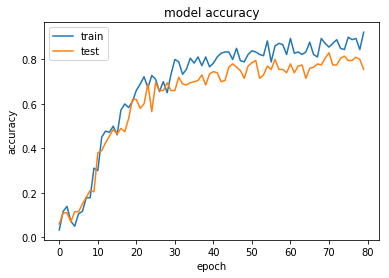

##############################
type: 1
Num in group on train: 3
Train acc:  0.905555546284
Val acc:  0.780000001192


Num in group on test: 3
Test acc: 0.809898989899


Num in group on test: 5
Test acc: 0.851515151515


Num in group on test: 7
Test acc: 0.874545454545


Num in group on test: 9
Test acc: 0.880808080808




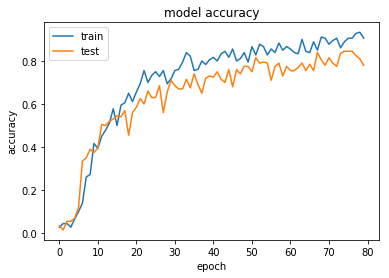

##############################
type: 1
Num in group on train: 5
Train acc:  0.927777767181
Val acc:  0.834999993443


Num in group on test: 3
Test acc: 0.762626262626


Num in group on test: 5
Test acc: 0.825454545455


Num in group on test: 7
Test acc: 0.849898989899


Num in group on test: 9
Test acc: 0.860606060606




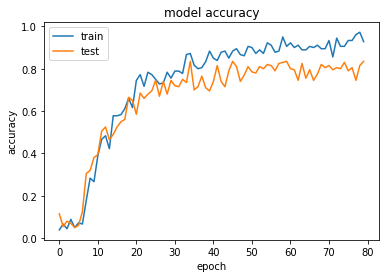

##############################
type: 1
Num in group on train: 9
Train acc:  0.922222216924
Val acc:  0.880000010133


Num in group on test: 3
Test acc: 0.752727272727


Num in group on test: 5
Test acc: 0.821414141414


Num in group on test: 7
Test acc: 0.839393939394


Num in group on test: 9
Test acc: 0.858787878788




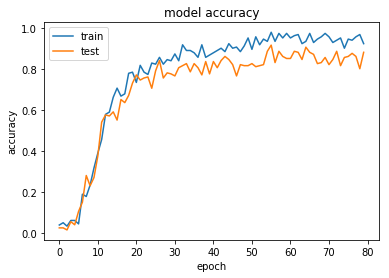

##############################
type: 2
Num in group on train: 2
Train acc:  0.861111104488
Val acc:  0.82500000298


Num in group on test: 3
Test acc: 0.847676767677


Num in group on test: 5
Test acc: 0.891111111111


Num in group on test: 7
Test acc: 0.914343434343


Num in group on test: 9
Test acc: 0.913737373737




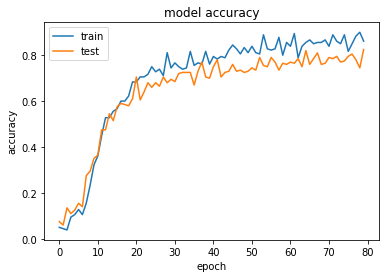

##############################
type: 2
Num in group on train: 3
Train acc:  0.927777767181
Val acc:  0.795000001788


Num in group on test: 3
Test acc: 0.819393939394


Num in group on test: 5
Test acc: 0.868686868687


Num in group on test: 7
Test acc: 0.890101010101


Num in group on test: 9
Test acc: 0.892929292929




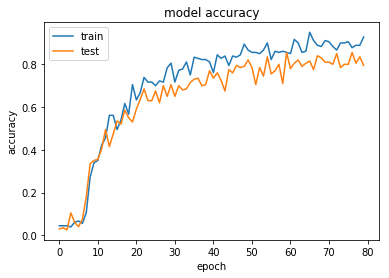

##############################
type: 2
Num in group on train: 5
Train acc:  0.966666658719
Val acc:  0.870000004768


Num in group on test: 3
Test acc: 0.805858585859


Num in group on test: 5
Test acc: 0.870909090909


Num in group on test: 7
Test acc: 0.894343434343


Num in group on test: 9
Test acc: 0.909292929293




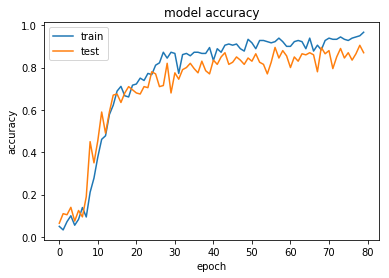

##############################
type: 2
Num in group on train: 9
Train acc:  0.961111108462
Val acc:  0.875


Num in group on test: 3
Test acc: 0.746262626263


Num in group on test: 5
Test acc: 0.816565656566


Num in group on test: 7
Test acc: 0.839191919192


Num in group on test: 9
Test acc: 0.867676767677




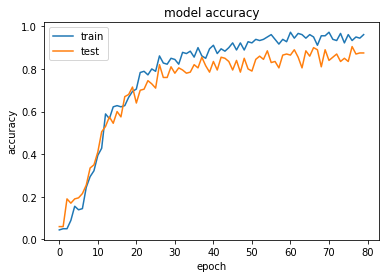

##############################
type: 3
Num in group on train: 2
Train acc:  0.855555554231
Val acc:  0.769999995828


Num in group on test: 3
Test acc: 0.833333333333


Num in group on test: 5
Test acc: 0.879797979798


Num in group on test: 7
Test acc: 0.89696969697


Num in group on test: 9
Test acc: 0.902828282828




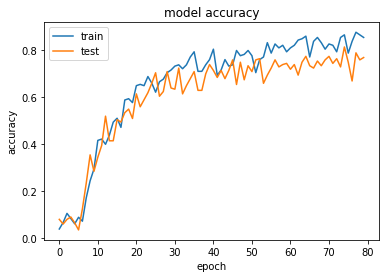

##############################
type: 3
Num in group on train: 3
Train acc:  0.949999988079
Val acc:  0.855000004172


Num in group on test: 3
Test acc: 0.850101010101


Num in group on test: 5
Test acc: 0.899595959596


Num in group on test: 7
Test acc: 0.915757575758


Num in group on test: 9
Test acc: 0.921616161616




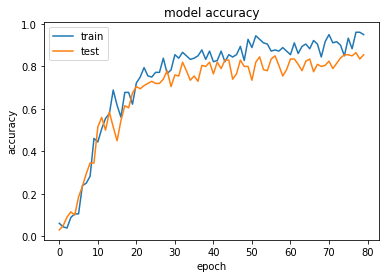

##############################
type: 3
Num in group on train: 5
Train acc:  0.899999996026
Val acc:  0.819999992847


Num in group on test: 3
Test acc: 0.756565656566


Num in group on test: 5
Test acc: 0.82404040404


Num in group on test: 7
Test acc: 0.857171717172


Num in group on test: 9
Test acc: 0.868484848485




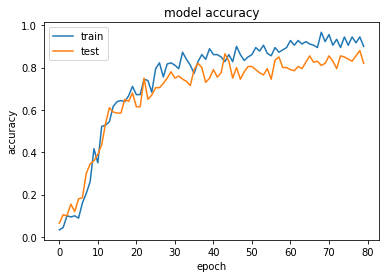

##############################
type: 3
Num in group on train: 9
Train acc:  0.977777759234
Val acc:  0.84999999404


Num in group on test: 3
Test acc: 0.725656565657


Num in group on test: 5
Test acc: 0.799595959596


Num in group on test: 7
Test acc: 0.826262626263


Num in group on test: 9
Test acc: 0.845656565657




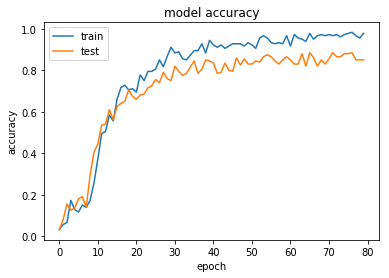

##############################
type: 4
Num in group on train: 2
Train acc:  0.861111104488
Val acc:  0.720000013709


Num in group on test: 3
Test acc: 0.832525252525


Num in group on test: 5
Test acc: 0.875757575758


Num in group on test: 7
Test acc: 0.889090909091


Num in group on test: 9
Test acc: 0.896161616162




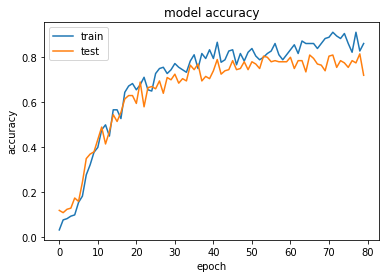

##############################
type: 4
Num in group on train: 3
Train acc:  0.911111096541
Val acc:  0.79999999702


Num in group on test: 3
Test acc: 0.819393939394


Num in group on test: 5
Test acc: 0.87797979798


Num in group on test: 7
Test acc: 0.892525252525


Num in group on test: 9
Test acc: 0.905050505051




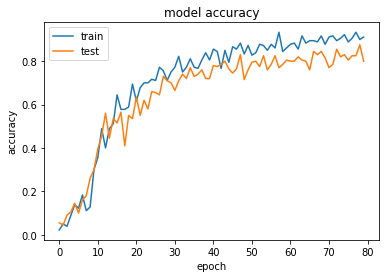

##############################
type: 4
Num in group on train: 5
Train acc:  0.938888887564
Val acc:  0.849999979138


Num in group on test: 3
Test acc: 0.790707070707


Num in group on test: 5
Test acc: 0.85696969697


Num in group on test: 7
Test acc: 0.87898989899


Num in group on test: 9
Test acc: 0.893939393939




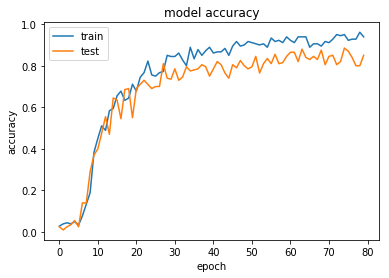

##############################
type: 4
Num in group on train: 9
Train acc:  0.933333317439
Val acc:  0.870000004768


Num in group on test: 3
Test acc: 0.729292929293


Num in group on test: 5
Test acc: 0.805050505051


Num in group on test: 7
Test acc: 0.834747474747


Num in group on test: 9
Test acc: 0.84




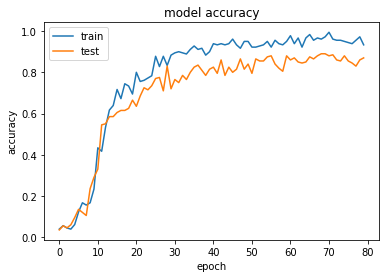

##############################
type: 5
Num in group on train: 2
Train acc:  0.861111104488
Val acc:  0.780000001192


Num in group on test: 3
Test acc: 0.843838383838


Num in group on test: 5
Test acc: 0.888282828283


Num in group on test: 7
Test acc: 0.90101010101


Num in group on test: 9
Test acc: 0.913333333333




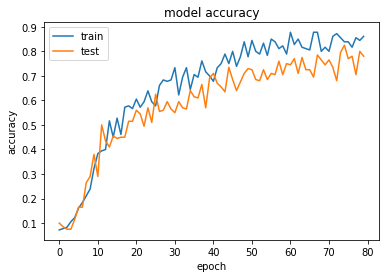

##############################
type: 5
Num in group on train: 3
Train acc:  0.905555566152
Val acc:  0.769999995828


Num in group on test: 3
Test acc: 0.809898989899


Num in group on test: 5
Test acc: 0.874545454545


Num in group on test: 7
Test acc: 0.894545454545


Num in group on test: 9
Test acc: 0.907878787879




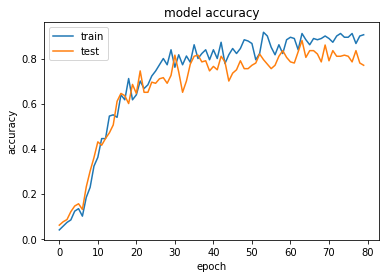

##############################
type: 5
Num in group on train: 5
Train acc:  0.92777778705
Val acc:  0.839999988675


Num in group on test: 3
Test acc: 0.788484848485


Num in group on test: 5
Test acc: 0.847474747475


Num in group on test: 7
Test acc: 0.870303030303


Num in group on test: 9
Test acc: 0.884848484848




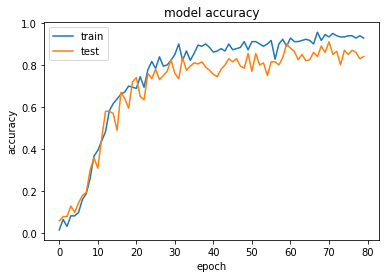

##############################
type: 5
Num in group on train: 9
Train acc:  0.972222208977
Val acc:  0.854999989271


Num in group on test: 3
Test acc: 0.732121212121


Num in group on test: 5
Test acc: 0.809898989899


Num in group on test: 7
Test acc: 0.845050505051


Num in group on test: 9
Test acc: 0.855353535354




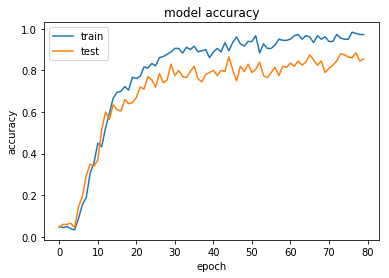

##############################
type: 6
Num in group on train: 2
Train acc:  0.777777771155
Val acc:  0.754999995232


Num in group on test: 3
Test acc: 0.829292929293


Num in group on test: 5
Test acc: 0.875555555556


Num in group on test: 7
Test acc: 0.896161616162


Num in group on test: 9
Test acc: 0.902828282828




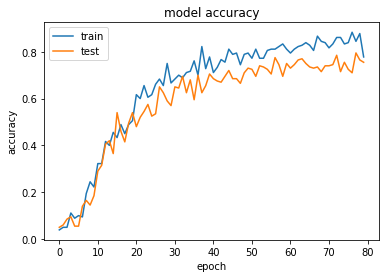

##############################
type: 6
Num in group on train: 3
Train acc:  0.905555546284
Val acc:  0.804999992251


Num in group on test: 3
Test acc: 0.82202020202


Num in group on test: 5
Test acc: 0.877171717172


Num in group on test: 7
Test acc: 0.891515151515


Num in group on test: 9
Test acc: 0.90202020202




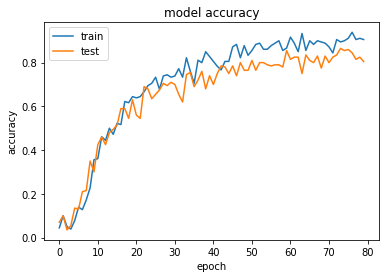

##############################
type: 6
Num in group on train: 5
Train acc:  0.938888907433
Val acc:  0.824999988079


Num in group on test: 3
Test acc: 0.777777777778


Num in group on test: 5
Test acc: 0.849090909091


Num in group on test: 7
Test acc: 0.868888888889


Num in group on test: 9
Test acc: 0.885454545455




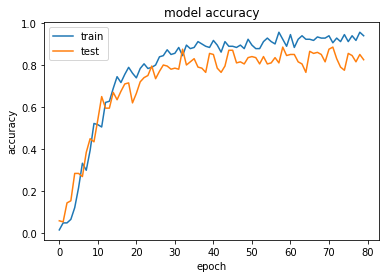

##############################
type: 6
Num in group on train: 9
Train acc:  0.972222208977
Val acc:  0.84999999404


Num in group on test: 3
Test acc: 0.725050505051


Num in group on test: 5
Test acc: 0.795757575758


Num in group on test: 7
Test acc: 0.838383838384


Num in group on test: 9
Test acc: 0.850707070707




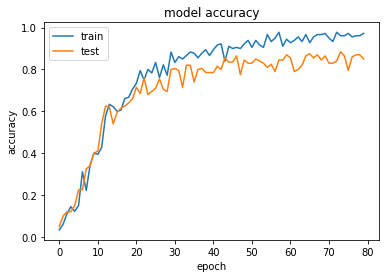

##############################
type: 7
Num in group on train: 2
Train acc:  0.916666666667
Val acc:  0.745000004768


Num in group on test: 3
Test acc: 0.827878787879


Num in group on test: 5
Test acc: 0.885454545455


Num in group on test: 7
Test acc: 0.900404040404


Num in group on test: 9
Test acc: 0.910909090909




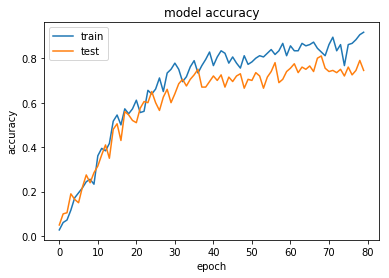

##############################
type: 7
Num in group on train: 3
Train acc:  0.933333337307
Val acc:  0.844999983907


Num in group on test: 3
Test acc: 0.825252525253


Num in group on test: 5
Test acc: 0.869292929293


Num in group on test: 7
Test acc: 0.894141414141


Num in group on test: 9
Test acc: 0.910101010101




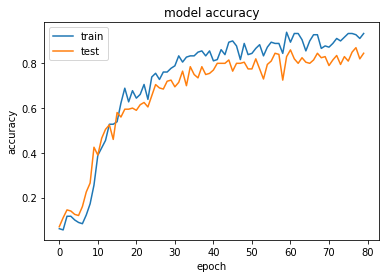

##############################
type: 7
Num in group on train: 5
Train acc:  0.922222236792
Val acc:  0.774999991059


Num in group on test: 3
Test acc: 0.745656565657


Num in group on test: 5
Test acc: 0.81595959596


Num in group on test: 7
Test acc: 0.84


Num in group on test: 9
Test acc: 0.852929292929




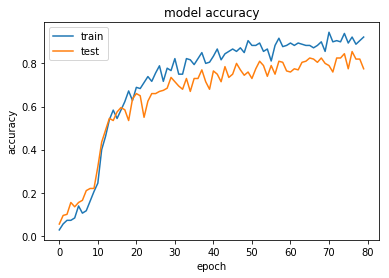

##############################
type: 7
Num in group on train: 9
Train acc:  0.949999988079
Val acc:  0.854999989271


Num in group on test: 3
Test acc: 0.729292929293


Num in group on test: 5
Test acc: 0.806868686869


Num in group on test: 7
Test acc: 0.836767676768


Num in group on test: 9
Test acc: 0.854949494949




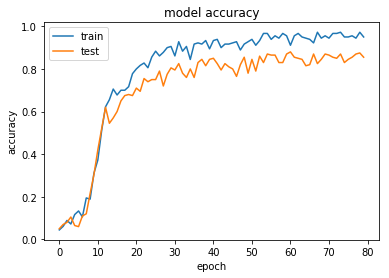

##############################
type: 8
Num in group on train: 2
Train acc:  0.844444453716
Val acc:  0.795000001788


Num in group on test: 3
Test acc: 0.829090909091


Num in group on test: 5
Test acc: 0.880606060606


Num in group on test: 7
Test acc: 0.900404040404


Num in group on test: 9
Test acc: 0.911515151515




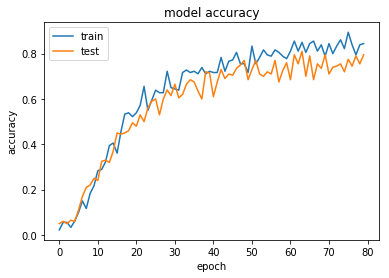

##############################
type: 8
Num in group on train: 3
Train acc:  0.894444465637
Val acc:  0.855000004172


Num in group on test: 3
Test acc: 0.823434343434


Num in group on test: 5
Test acc: 0.865454545455


Num in group on test: 7
Test acc: 0.896363636364


Num in group on test: 9
Test acc: 0.905858585859




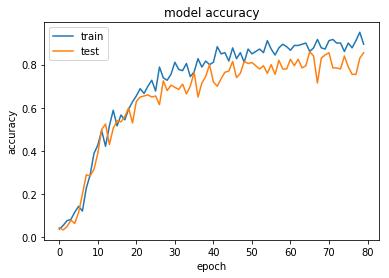

##############################
type: 8
Num in group on train: 5
Train acc:  0.944444437822
Val acc:  0.844999998808


Num in group on test: 3
Test acc: 0.780808080808


Num in group on test: 5
Test acc: 0.860606060606


Num in group on test: 7
Test acc: 0.884646464646


Num in group on test: 9
Test acc: 0.893535353535




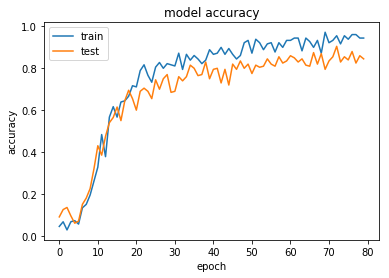

##############################
type: 8
Num in group on train: 9
Train acc:  0.972222228845
Val acc:  0.879999995232


Num in group on test: 3
Test acc: 0.768484848485


Num in group on test: 5
Test acc: 0.845252525253


Num in group on test: 7
Test acc: 0.874747474747


Num in group on test: 9
Test acc: 0.893131313131




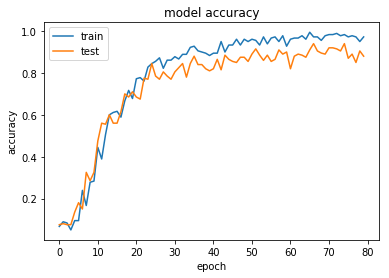

In [284]:
# training&testing NNs
epochs = 80
num_in_group_on_train = [2,3,5,9]
num_in_group_on_test = [3, 5, 7, 9]
conv_cnn_defs = [conv_cnn_1, conv_cnn_2, conv_cnn_3,conv_cnn_4,conv_cnn_5,conv_cnn_6,conv_cnn_7,conv_cnn_8]
ensemble_defs = [ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5, ensemble_6, ensemble_7, ensemble_8]
all_models = []

for i in tqdm_notebook(range(8)):
    one_model_type = []
    for j in num_in_group_on_train:
        print("##############################")
        print ("type:", i+1)
        print ("Num in group on train:", j)
        trained_model, single_cnn, hist = creating_training_net(conv_cnn_defs[i], ensemble_defs[i], j, epochs)
        print("Train acc: ", hist.history['acc'][-1])
        print("Val acc: ", hist.history['val_acc'][-1])
        print("\n")
        for k in num_in_group_on_test:
            Testing(i, trained_model, single_cnn, k)
            print("\n")
        print_training_curv(hist)
        one_model_type.append(trained_model)
    all_models.append(one_model_type)